# Customer Lifetime Value Predictions

In this notebook a machine learning model will be built to predict Customer Lifetime Value (CLV) of an online retail store.

Data can be found here:
*https://www.kaggle.com/datasets/vijayuv/onlineretail*


Step-by-step process:

- Define an appropriate time frame for Customer Lifetime Value calculation
- Identify the features we are going to use to predict future value and create them
- Calculate lifetime value (LTV) for training the machine learning model
- Build and run the machine learning model
- Check if the model is useful

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import plotly.express as px

from datetime import datetime, timedelta, date

## Data Import

In [2]:
data = pd.read_csv("../data/OnlineRetail.csv",encoding= 'unicode_escape')

In [3]:
data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

In [4]:
data.shape

(541909, 8)

In [5]:
data.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

## Data Cleaning

Cleaning data

### Missing Values

In [6]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
data.loc[data.CustomerID.isnull() == True].tail()

InvoiceNo StockCode                     Description  Quantity  \
541536    581498    85099B         JUMBO BAG RED RETROSPOT         5   
541537    581498    85099C  JUMBO  BAG BAROQUE BLACK WHITE         4   
541538    581498     85150   LADIES & GENTLEMEN METAL SIGN         1   
541539    581498     85174               S/4 CACTI CANDLES         1   
541540    581498       DOT                  DOTCOM POSTAGE         1   

            InvoiceDate  UnitPrice  CustomerID         Country  
541536  12/9/2011 10:26       4.13         NaN  United Kingdom  
541537  12/9/2011 10:26       4.13         NaN  United Kingdom  
541538  12/9/2011 10:26       4.96         NaN  United Kingdom  
541539  12/9/2011 10:26      10.79         NaN  United Kingdom  
541540  12/9/2011 10:26    1714.17         NaN  United Kingdom

In [8]:
data.dropna(axis=0, inplace= True)

In [9]:
data.shape

(406829, 8)

### Duplicates

In [10]:
## assessing the nr. of duplicates in the dataset
data.duplicated().sum()

5225

In [11]:
data.loc[data.duplicated() == True].tail()

InvoiceNo StockCode                     Description  Quantity  \
541675    581538     22068     BLACK PIRATE TREASURE CHEST         1   
541689    581538     23318  BOX OF 6 MINI VINTAGE CRACKERS         1   
541692    581538     22992          REVOLVER WOODEN RULER          1   
541699    581538     22694                    WICKER STAR          1   
541701    581538     23343    JUMBO BAG VINTAGE CHRISTMAS          1   

            InvoiceDate  UnitPrice  CustomerID         Country  
541675  12/9/2011 11:34       0.39     14446.0  United Kingdom  
541689  12/9/2011 11:34       2.49     14446.0  United Kingdom  
541692  12/9/2011 11:34       1.95     14446.0  United Kingdom  
541699  12/9/2011 11:34       2.10     14446.0  United Kingdom  
541701  12/9/2011 11:34       2.08     14446.0  United Kingdom

The rows which are denoted as duplicates are sufficiently dissimilar to be valid data entries, and are therefore kept in the data.

### Outliers

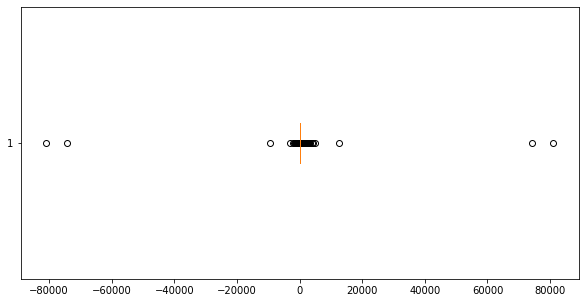

In [12]:
## Inspecting Outliers in Quantity
plt.figure(figsize= (10,5))
plt.boxplot(data.Quantity, vert= False);

In [13]:
## inspecting the orders with the highest quantity
data.sort_values(by="Quantity", ascending=False).head(2)

InvoiceNo StockCode                     Description  Quantity  \
540421    581483     23843     PAPER CRAFT , LITTLE BIRDIE     80995   
61619     541431     23166  MEDIUM CERAMIC TOP STORAGE JAR     74215   

            InvoiceDate  UnitPrice  CustomerID         Country  
540421   12/9/2011 9:15       2.08     16446.0  United Kingdom  
61619   1/18/2011 10:01       1.04     12346.0  United Kingdom

As there is no Information regarding whether the orders are valid or not, they will be dropped, in order not to skew the rest of the data.

In [14]:
## dropping rows where Quantity is negative, as well as outliers in quantity
idx = data.loc[data.Quantity < 0].index

data.drop(idx, inplace= True)

idx = data.sort_values(by="Quantity", ascending=False).head(2).index

data.drop(idx, inplace= True)

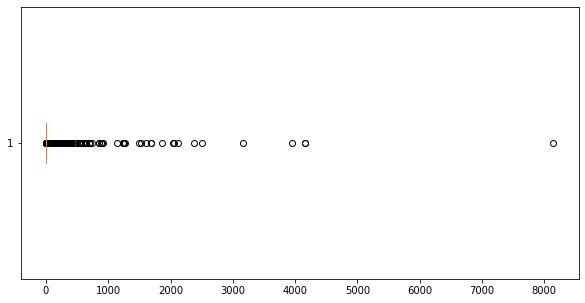

In [15]:
## Inspecting outliers in UnitPrice
plt.figure(figsize= (10,5))
plt.boxplot(data.UnitPrice, vert= False);

In [16]:
data.loc[data.UnitPrice == data.UnitPrice.max()]

InvoiceNo StockCode Description  Quantity     InvoiceDate  UnitPrice  \
173382    551697      POST     POSTAGE         1  5/3/2011 13:46    8142.75   

        CustomerID         Country  
173382     16029.0  United Kingdom

As there is no information regarding validity of the unit prices, and they appear reasonable, they will be left in the data.

In [17]:
## changing InvoiceDate data type to datetime
data["InvoiceDate"] = pd.to_datetime(data.InvoiceDate)

In [18]:
data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

## Data Exploration

Exploring statistical trends and distributions

In [19]:
data.head(3)

InvoiceNo StockCode                         Description  Quantity  \
0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                 WHITE METAL LANTERN         6   
2    536365    84406B      CREAM CUPID HEARTS COAT HANGER         8   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom

In [20]:
## showing a statistical summary of the distribution of Quantity
data.Quantity.describe()

count    397922.000000
mean         12.631837
std          47.263643
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       12540.000000
Name: Quantity, dtype: float64

In [21]:
## inspecting the amount of individual customers
print(f"\nThere are, in total, {len(data.CustomerID.unique())} customers.\n")


There are, in total, 4338 customers.



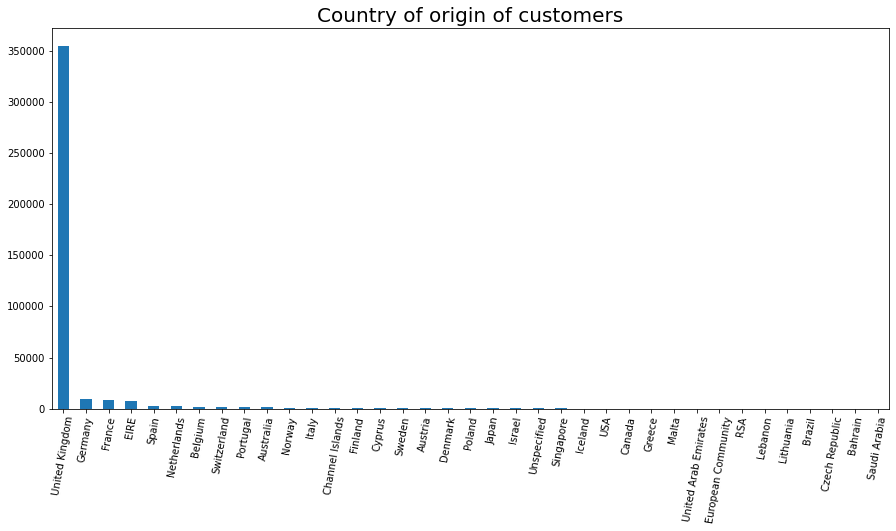

In [22]:
## inspecting country of origin of the customers
plt.figure(figsize=(15,7))
data.Country.value_counts().plot(kind="bar")
plt.title("Country of origin of customers", size=20)
plt.xticks(rotation=80);

In [23]:
## inspecting the timeframe of the dataset
earliest_date = data.InvoiceDate.min().date()
latest_date = data.InvoiceDate.max().date()

print(f"\nOrders in the dataset range from {earliest_date} to {latest_date}\n")


Orders in the dataset range from 2010-12-01 to 2011-12-09



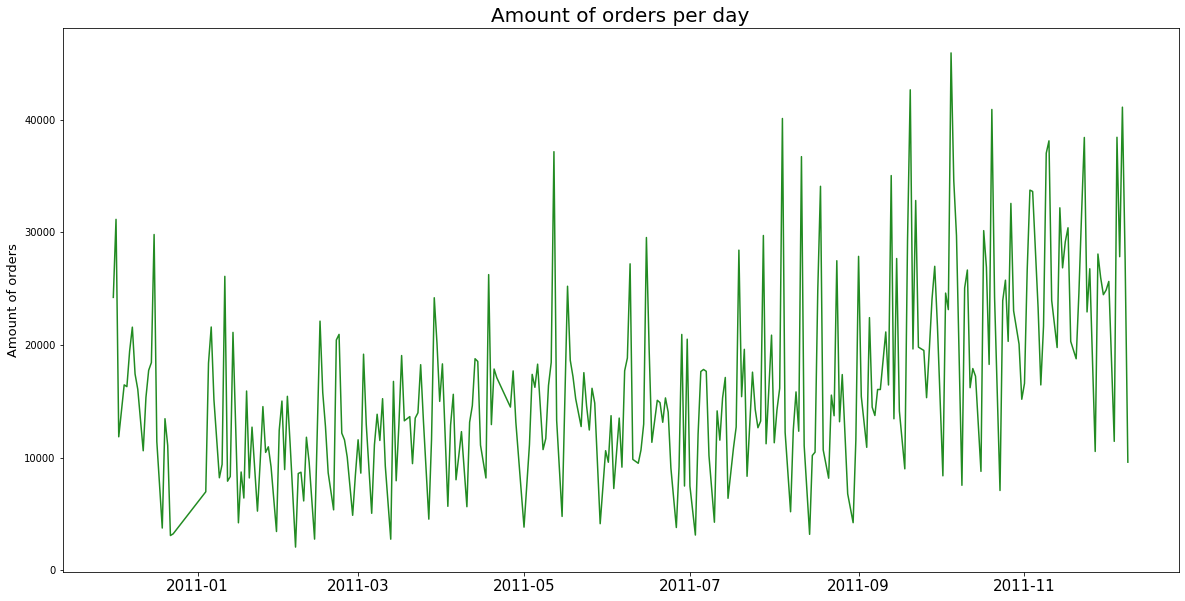

In [24]:
## inspecting amount of orders per day
date_df = data.copy()

date_df["date"] = date_df["InvoiceDate"].apply(lambda x: x.date())

date_df = pd.DataFrame(date_df.groupby("date")["Quantity"].sum()).reset_index().sort_values(by="date")

## plotting the distribution
plt.figure(figsize=(20,10))
plt.plot(date_df.date, date_df.Quantity, c= "forestgreen")
plt.title("Amount of orders per day", size=20)
plt.xticks(size=15)
plt.ylabel("Amount of orders", size=13);

### Calculating Revenue

In [25]:
## calculating revenue as sum of quantity and unit price per order
data["Revenue"] = data["Quantity"] * data["UnitPrice"]

## Customer Segmentation

This section segments customers into clusters based on Recency, Frequency and Monetary Value.

These features will then be used to forecast CLV.

In the first step, only the 3 months of data will be analysed and processed, which will then be used to predict the next 6 months.

# --New Approach to Segmentation--

In [26]:
data = data.loc[data['InvoiceDate'] < '2011-12-01']

In [27]:
data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  Revenue  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom    15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom    22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34

In [28]:
def groupby_mean(x):
    return x.mean()

def groupby_count(x):
    return x.count()

def purchase_duration(x):
    return (x.max() - x.min()).days

def avg_frequency(x):
    return (x.max() - x.min()).days / x.count()

groupby_mean.__name__ = 'avg'
groupby_count.__name__ = 'count'
purchase_duration.__name__ = 'purchase_duration'
avg_frequency.__name__ = 'purchase_frequency'

In [29]:
def group_by_3M(df, clv_freq):
    '''This function slices the dataframe into chunks of a select timeframe.
    This is done so that previous timeframes can be used to predict CLV for a later timeframe.
    Ex.: Slicing into 3 months timeframes, to predict the last chunk based on all previous ones.'''
    
    df_orders = df.groupby(['CustomerID', 'InvoiceNo']).agg({'Revenue': sum, 'InvoiceDate': max})

    df_data = df_orders.reset_index().groupby([
                'CustomerID',
                pd.Grouper(key='InvoiceDate', freq=clv_freq)
                ]).agg({'Revenue': [sum, groupby_mean, groupby_count],})

    df_data.columns = ['_'.join(col).lower() for col in df_data.columns]
    
    df_data.reset_index(inplace= True)
    
    map_date_month = {str(x)[:10]: 'M_%s' % (i+1) for i, x in enumerate(
                    sorted(df_data.reset_index()['InvoiceDate'].unique(), reverse=True))}
    
    df_data["M"] = df_data["InvoiceDate"].apply(lambda x: map_date_month[str(x)[:10]])
    
    return df_data
    
    

In [30]:
df_data = group_by_3M(data, clv_freq='3M')

df_data.head()

CustomerID InvoiceDate  revenue_sum  revenue_avg  revenue_count    M
0     12347.0  2010-12-31       711.79      711.790              1  M_5
1     12347.0  2011-03-31       475.39      475.390              1  M_4
2     12347.0  2011-06-30      1018.77      509.385              2  M_3
3     12347.0  2011-09-30       584.91      584.910              1  M_2
4     12347.0  2011-12-31      1294.32     1294.320              1  M_1

In [31]:
def create_features_and_target(df):
    '''This function takes the monthly aggregated data, and creates features
    as inputs for our regression from it.'''
    
    ## create features
    df_features = pd.pivot_table(
                    df.loc[df["M"] != "M_1"],
                    values= ["revenue_sum", "revenue_avg", "revenue_count"],
                    columns = "M",
                    index= "CustomerID")
    
    df_features.columns = ['_'.join(col) for col in df_features.columns]
    
    df_features.reset_index(level=0, inplace= True)
    
    df_features.fillna(0, inplace=True)
    
    ## create target
    df_target = df.loc[df["M"] == "M_1"][["CustomerID", "revenue_sum"]]

    df_target.columns = ["CustomerID", "CLV_M_1"]
    
    ## creating final dataframe by merging
    df_final = pd.merge(df_features, df_target, on= "CustomerID", how= "left")
    
    df_final.fillna(0, inplace=True)
    
    return df_final

In [32]:
df_final = create_features_and_target(df_data)

In [33]:
df_final.head()

CustomerID  revenue_avg_M_2  revenue_avg_M_3  revenue_avg_M_4  \
0     12347.0           584.91          509.385          475.390   
1     12348.0           310.00          367.000          227.440   
2     12350.0             0.00            0.000          334.400   
3     12352.0           316.25            0.000          312.362   
4     12353.0             0.00           89.000            0.000   

   revenue_avg_M_5  revenue_count_M_2  revenue_count_M_3  revenue_count_M_4  \
0           711.79                1.0                2.0                1.0   
1           892.80                1.0                1.0                1.0   
2             0.00                0.0                0.0                1.0   
3             0.00                2.0                0.0                5.0   
4             0.00                0.0                1.0                0.0   

   revenue_count_M_5  revenue_sum_M_2  revenue_sum_M_3  revenue_sum_M_4  \
0                1.0           584.91          1018.77           475.39   
1                1.0           310.00           367.00           227.44   
2                0.0             0.00             0.00           334.40   
3                0.0           632.50             0.00          1561.81   
4                0.0             0.00            89.00             0.00   

   revenue_sum_M_5  CLV_M_1  
0           711.79  1294.32  
1           892.80     0.00  
2             0.00     0.00  
3             0.00   311.73  
4             0.00     0.00

In [34]:
df_final.shape

(3615, 14)

### Build linear regression

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error, r2_score

In [161]:
def regression(df, target):
    
    X= df.drop([target, "CustomerID"], axis= 1)
    y= df[target]
    
    lm = LinearRegression()
    
    cv_result= cross_validate(lm,
                             X,
                             y,
                             cv= 5,
                             scoring= ('r2', 'neg_mean_absolute_error'))
    
    r2 = cv_result['test_r2'].mean()
    mae = abs(cv_result['test_neg_mean_absolute_error'].mean())
    
    print(f"Results: \nr2 = {round(r2,2)}\nMAE = {round(mae,2)}")
    
    return lm

In [162]:
regression(df_final, "CLV_M_1")

Results: 
r2 = 0.63
MAE = 438.24


LinearRegression()

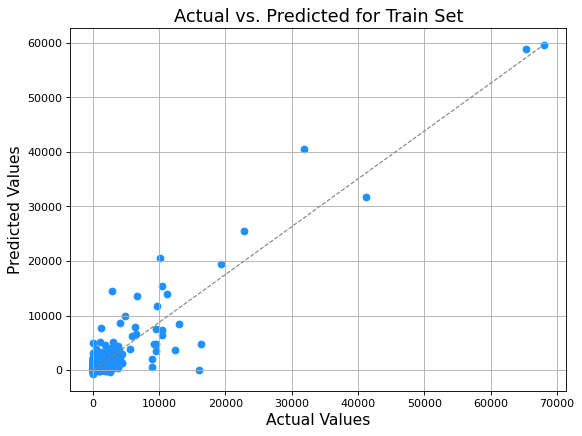

In [40]:
plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(y_train, train_preds, color='dodgerblue')
plt.plot([0, max(y_train)], [0, max(train_preds)], color='gray', lw=1, linestyle='--')

plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.title('Actual vs. Predicted for Train Set', fontsize=16)
plt.grid()

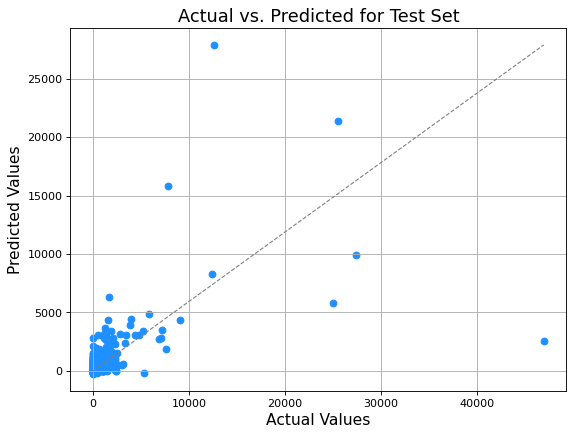

In [41]:
plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(y_test, y_pred, color='dodgerblue')
plt.plot([0, max(y_test)], [0, max(y_pred)], color='gray', lw=1, linestyle='--')

plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.title('Actual vs. Predicted for Test Set', fontsize=16)
plt.grid()

In [45]:
coef = pd.DataFrame(list(zip(X.columns, lm.coef_)))
coef.columns = ['feature', 'coef']

In [46]:
coef

feature        coef
0     revenue_avg_M_2    0.029124
1     revenue_avg_M_3   -0.514172
2     revenue_avg_M_4   -0.038232
3     revenue_avg_M_5   -0.511240
4   revenue_count_M_2   68.928884
5   revenue_count_M_3   78.709599
6   revenue_count_M_4 -142.380130
7   revenue_count_M_5  -71.663413
8     revenue_sum_M_2    0.221419
9     revenue_sum_M_3    0.289439
10    revenue_sum_M_4    0.327828
11    revenue_sum_M_5    0.883301

### Regression using XGB on df_final

In [197]:
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error
from sklearn.dummy import DummyClassifier, DummyRegressor

In [198]:
X = df_final.drop(["CustomerID", "CLV_M_1"], axis= 1)
y = df_final["CLV_M_1"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25)

In [199]:
xgb_regressor = xgb.XGBRegressor()

xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

r2 = xgb_regressor.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

results = {
    "metric": ["r2", "mse", "rmse", "mae"],
    "value": [r2, mse, rmse, mae]
}

pd.DataFrame(results).set_index("metric").round(2)

value
metric           
r2           0.31
mse     988415.79
rmse       994.19
mae        383.65

In [47]:
## making 3 - months and 6 - months dataframes
data_3m = data[(data.InvoiceDate.dt.date < date(2011,6,1)) & (data.InvoiceDate.dt.date >= date(2011,3,1))].reset_index()
data_6m = data[(data.InvoiceDate.dt.date >= date(2011,6,1)) & (data.InvoiceDate.dt.date < date(2011,12,1))].reset_index()

In [48]:
data_3m.shape

(78143, 10)

### Calculating *Recency*

Finding out most recent purchase date for each customer, and see how many days they have been inactive for.

Afterwards, k-Means clustering will be applied to assign a *recency score*.

In [49]:
## creating a new dataframe using customer ID
user_df = pd.DataFrame(data_3m.CustomerID.unique(), columns= ["CustomerID"])

In [50]:
## get the latest purchase date for each customer and assign it to a new column
latest_purchase_df = pd.DataFrame(data_3m.groupby("CustomerID").InvoiceDate.max().reset_index())
latest_purchase_df.columns = ["CustomerID", "LatestPurchaseDate"]

In [51]:
## calculate difference between observation date (overall latest invoice date) 
## and latest invoice date per customer
latest_purchase_df["Recency"] = (data_3m.InvoiceDate.max() - latest_purchase_df["LatestPurchaseDate"]).dt.days

In [52]:
## merge the dataframe
recency_df = pd.merge(user_df, latest_purchase_df[["CustomerID", "Recency"]], on="CustomerID")

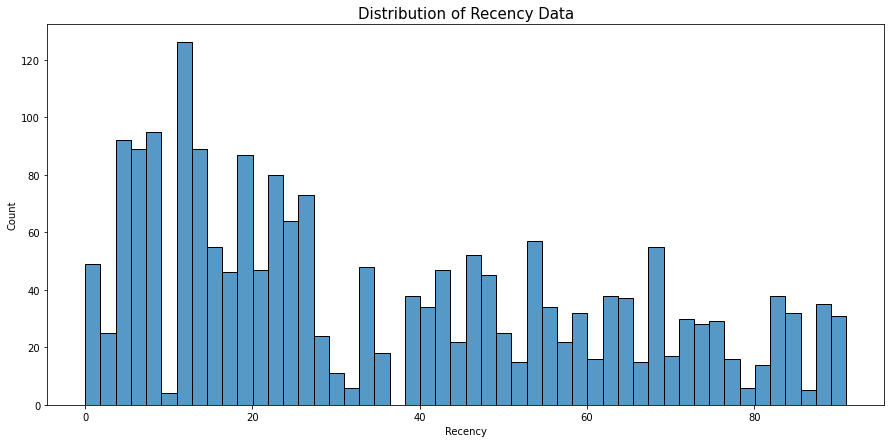

In [53]:
## plotting recency
plt.figure(figsize=(15,7))
sns.histplot(data=recency_df.Recency, bins=50)
plt.title("Distribution of Recency Data", size=15);

In [54]:
## statistical summary of recency data
recency_df.Recency.describe()

count    1993.000000
mean       35.801305
std        26.042012
min         0.000000
25%        13.000000
50%        27.000000
75%        56.000000
max        91.000000
Name: Recency, dtype: float64

In [55]:
## applying K-Means Clustering
from sklearn.cluster import KMeans

sse= {}
recency = recency_df[["Recency"]]
for k in range(1,10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

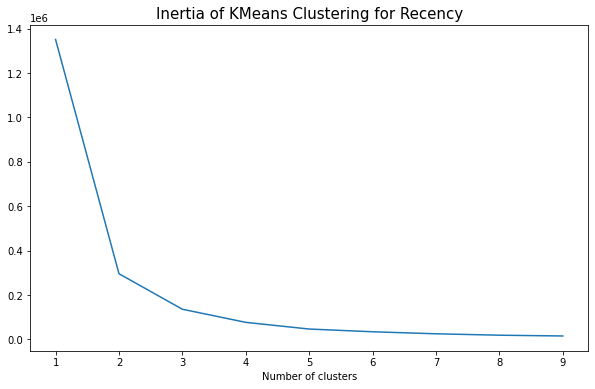

In [56]:
## plotting inertia to determine optimal nr. of clusters
plt.figure(figsize=(10,6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.title("Inertia of KMeans Clustering for Recency", size=15);

According to the inertia graph, 3 appears to be the optimal number of clusters.

In [57]:
## assigning clusters to all customers in the dataset
kmeans = KMeans(n_clusters= 3)
kmeans.fit(recency_df[["Recency"]])
recency_df["RecencyCluster"] = kmeans.predict(recency_df[["Recency"]])

In [58]:
## function for ordering cluster numbers, to have an order based on "value"
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    
    new_cluster_field_name = 'new_' + cluster_field_name
    
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    
    df_new['index'] = df_new.index
    
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    
    df_final = df_final.drop([cluster_field_name],axis=1)
    
    df_final = df_final.rename(columns={"index":cluster_field_name})
    
    return df_final

In [59]:
## applying order_cluster() to recency_df
recency_df = order_cluster('RecencyCluster', 'Recency',recency_df,False)

In [60]:
## inspecting statistics for all clusters
recency_df.groupby("RecencyCluster")["Recency"].describe()

count       mean       std   min   25%   50%   75%   max
RecencyCluster                                                           
0                442.0  74.893665  9.238832  61.0  68.0  74.0  83.0  91.0
1                495.0  46.503030  7.823165  32.0  41.0  47.0  53.0  60.0
2               1056.0  14.422348  8.043462   0.0   8.0  14.0  21.0  30.0

In [61]:
recency_df.head()

CustomerID  Recency  RecencyCluster
0     14620.0       13               2
1     14740.0        4               2
2     13880.0       25               2
3     17068.0       11               2
4     12971.0        4               2

In [62]:
## including recency data in user_df
user_df= pd.merge(user_df, recency_df, on= "CustomerID")

### Calculating Frequency

Find the total number of orders for each customer

In [63]:
## making dataframe with total number of orders per customer
frequency_df = data_3m.groupby("CustomerID").InvoiceDate.count().reset_index()
frequency_df.columns = ["CustomerID", "Frequency"]

frequency_df.head()

CustomerID  Frequency
0     12347.0         24
1     12348.0          5
2     12352.0         23
3     12353.0          4
4     12354.0         58

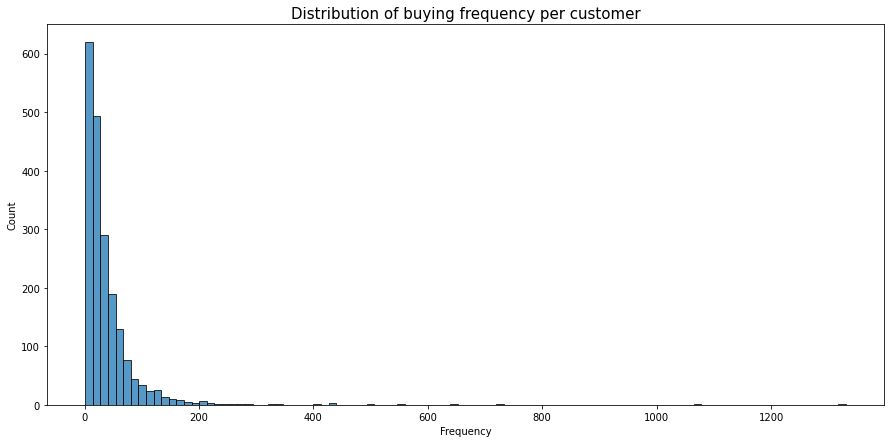

In [64]:
## plotting the distribution
plt.figure(figsize=(15,7))
sns.histplot(frequency_df["Frequency"], bins=100)
plt.title("Distribution of buying frequency per customer", size=15);

In [65]:
## applying frequency clusters

sse= {}
frequency = frequency_df[["Frequency"]]
for k in range(1,10):
    kmeans= KMeans(n_clusters= k, max_iter=1000).fit(frequency)
    frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

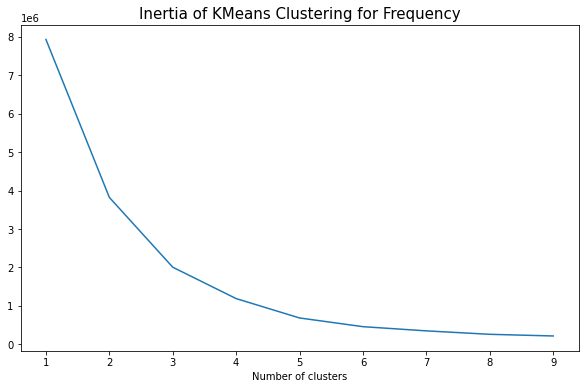

In [66]:
## plotting inertia
plt.figure(figsize=(10,6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.title("Inertia of KMeans Clustering for Frequency", size=15);

It appears that the best number of clusters is 5.

In [67]:
## fitting the clusters to the customers
kmeans = KMeans(n_clusters= 5, max_iter=1000).fit(frequency_df[["Frequency"]])
frequency_df["FrequencyCluster"] = kmeans.predict(frequency_df[["Frequency"]])

In [68]:
frequency_df = order_cluster("FrequencyCluster", "Frequency", frequency_df, True)

In [69]:
## inspecting statistics for all clusters
frequency_df.groupby("FrequencyCluster")["Frequency"].describe()

count         mean         std     min     25%     50%  \
FrequencyCluster                                                            
0                 1319.0    16.206217    9.516534     1.0     8.0    15.0   
1                  539.0    57.586271   16.585631    37.0    43.0    54.0   
2                  121.0   145.652893   41.662475   102.0   115.0   131.0   
3                   12.0   474.666667  127.679523   328.0   391.0   436.0   
4                    2.0  1204.000000  179.605122  1077.0  1140.5  1204.0   

                      75%     max  
FrequencyCluster                   
0                   23.00    36.0  
1                   68.00   101.0  
2                  165.00   282.0  
3                  558.25   730.0  
4                 1267.50  1331.0

In [70]:
## including frequency data in user_df
user_df= pd.merge(user_df, frequency_df, on= "CustomerID")

### Calculating Monetary Value

Clustering Customers based on Revenue.

In [71]:
## assessing total revenue per customer
revenue_df = data_3m.groupby("CustomerID")["Revenue"].sum().reset_index()

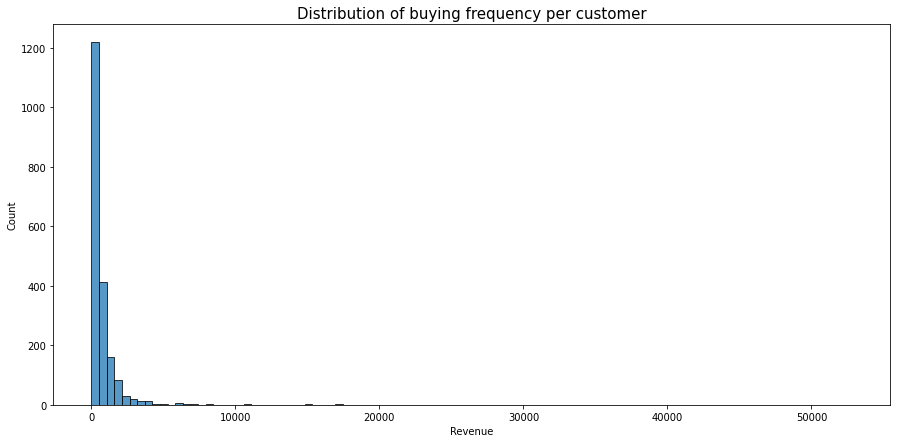

In [72]:
## plotting the revenue distribution
plt.figure(figsize=(15,7))
sns.histplot(revenue_df["Revenue"], bins=100)
plt.title("Distribution of buying frequency per customer", size=15);

In [73]:
## clustering based on revenue
sse = {}
revenue = revenue_df[["Revenue"]]
for k in range(1,10):
    kmeans= KMeans(n_clusters= k, max_iter= 1000).fit(revenue)
    revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

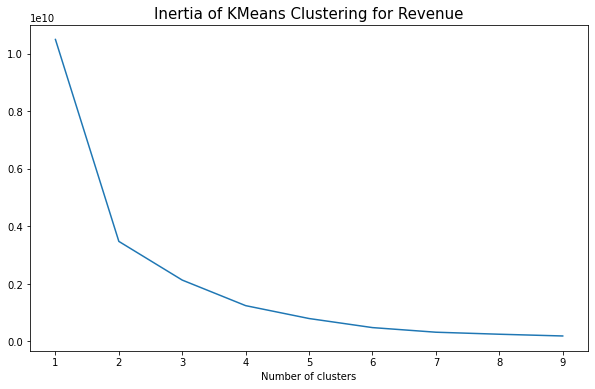

In [74]:
## plotting inertia
plt.figure(figsize=(10,6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.title("Inertia of KMeans Clustering for Revenue", size=15);

Based on the inertia plot, the optimal number of clusters is 5.

In [75]:
## clustering customers based on revenue
kmeans = KMeans(n_clusters= 5, max_iter= 1000)
kmeans.fit(revenue_df[["Revenue"]])

revenue_df["RevenueCluster"] = kmeans.predict(revenue_df[["Revenue"]])

revenue_df = order_cluster("RevenueCluster", "Revenue", revenue_df, True)

In [76]:
## inspecting descriptive statistics for all revenue clusters
revenue_df.groupby("RevenueCluster")["Revenue"].describe()

count          mean           std       min        25%  \
RevenueCluster                                                            
0               1684.0    415.442280    275.802105      2.90    203.930   
1                270.0   1981.387670    775.833113   1199.25   1438.925   
2                 25.0   7387.236800   2060.013397   4867.90   6249.760   
3                 11.0  18755.360909   3715.648243  14984.73  16556.415   
4                  3.0  39242.106667  12081.365101  29768.00  32439.610   

                      50%         75%       max  
RevenueCluster                                   
0                 336.545    572.0625   1193.88  
1                1703.820   2273.9725   4514.24  
2                6764.490   8051.5900  12382.32  
3               17429.190  19845.4400  26272.02  
4               35111.220  43979.1600  52847.10

In [77]:
## including revenue data in user_df
user_df= pd.merge(user_df, revenue_df, on= "CustomerID")

### Making final dataframe

In [78]:
user_df.head()

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  Revenue  \
0     14620.0       13               2         26                 0   412.78   
1     14740.0        4               2         89                 1  1448.21   
2     13880.0       25               2         38                 1   718.63   
3     16462.0       91               0          1                 0    34.00   
4     17068.0       11               2         76                 1  1480.95   

   RevenueCluster  
0               0  
1               1  
2               0  
3               0  
4               1

In [79]:
## applying over all scoring by adding cluster numbers
user_df["OverallScore"] = user_df["RecencyCluster"] + user_df["FrequencyCluster"] + user_df["RevenueCluster"]

In [80]:
## creating the final dataframe
user_df.groupby("OverallScore")["Recency", "Frequency", "Revenue"].mean()

/var/folders/2s/hl8h12kx35b4f1bh9818nxj00000gn/T/ipykernel_5358/3038707750.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  user_df.groupby("OverallScore")["Recency", "Frequency", "Revenue"].mean()


Recency   Frequency       Revenue
OverallScore                                     
0             75.181556   13.927954    279.402305
1             51.553531   22.189066    385.407267
2             21.586103   23.980363    454.831601
3             17.697279   52.380952    896.029626
4             13.533333   83.120000   2075.772800
5             11.813333  135.666667   3194.538947
6              9.230769  292.846154   8040.364615
7              7.285714  287.714286  16028.871429
8             10.500000  605.750000  16906.650000
9              5.000000  703.500000  38654.140000

In [81]:
## binning the clusters into classes
user_df["Segment"] = 'Low-Value'
user_df["Segment"].loc[user_df.OverallScore>3] = "Mid-Value"
user_df["Segment"].loc[user_df.OverallScore>6] = "High-Value"

/Users/garritwilson/.pyenv/versions/3.8.12/envs/li-monitoring/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [82]:
## inspecting the final dataframe
user_df.head()

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  Revenue  \
0     14620.0       13               2         26                 0   412.78   
1     14740.0        4               2         89                 1  1448.21   
2     13880.0       25               2         38                 1   718.63   
3     16462.0       91               0          1                 0    34.00   
4     17068.0       11               2         76                 1  1480.95   

   RevenueCluster  OverallScore    Segment  
0               0             2  Low-Value  
1               1             4  Mid-Value  
2               0             3  Low-Value  
3               0             0  Low-Value  
4               1             4  Mid-Value

## Plotting the customer segmentation

In [83]:
## dropping outliers in frequency

for col in ["Frequency", "Recency", "Revenue"]:

    mask = user_df[col] > user_df[col].quantile(0.99)

    user_df.drop(user_df[mask].index, inplace=True)

## plotting with plotly
fig = px.scatter_3d(user_df, x='Frequency', y='Recency', z='Revenue', color= "OverallScore",
                   size_max=5, opacity= 0.6)

fig.show()

In [84]:
user_df.shape

(1940, 9)

### Calculating 6-months lifetime value (LTV)

The 6-months LTV is going to be used for training the machine learning algorithm.

As this is going to be a supervised learning task, the RFM features that have just been created will be used to predict the 6-months LTV, which will be calculated next.

In [85]:
## making the 6m user dataframe with the sum of revenue generated per customer
user_df_6m = data_6m.groupby("CustomerID")["Revenue"].sum().reset_index()
user_df_6m.columns = ["CustomerID", "6m_Revenue"]

In [86]:
## visualizing the distribution of revenue per customer
plt.figure(figsize=(15,7))
sns.histplot(user_df_6m["6m_Revenue"], bins= 50)

<AxesSubplot:xlabel='6m_Revenue', ylabel='Count'>

In [87]:
## merging 6-months and 3-months dataframes
df_merged = pd.merge(user_df, user_df_6m, on="CustomerID", how='left')
df_merged.shape

(1940, 10)

In [88]:
## as there are nan-values in the dataset, they will be dropped
df_merged.dropna(inplace=True)
df_merged.shape

(1457, 10)

In [89]:
## removing outliers from df_merged
df_merged = df_merged[df_merged['6m_Revenue'] < df_merged["6m_Revenue"].quantile(0.99)]

In [90]:
df_merged["6m_Revenue"].describe()

count     1442.000000
mean      1399.377879
std       1543.630260
min          7.500000
25%        397.765000
50%        900.080000
75%       1773.467500
max      10665.820000
Name: 6m_Revenue, dtype: float64

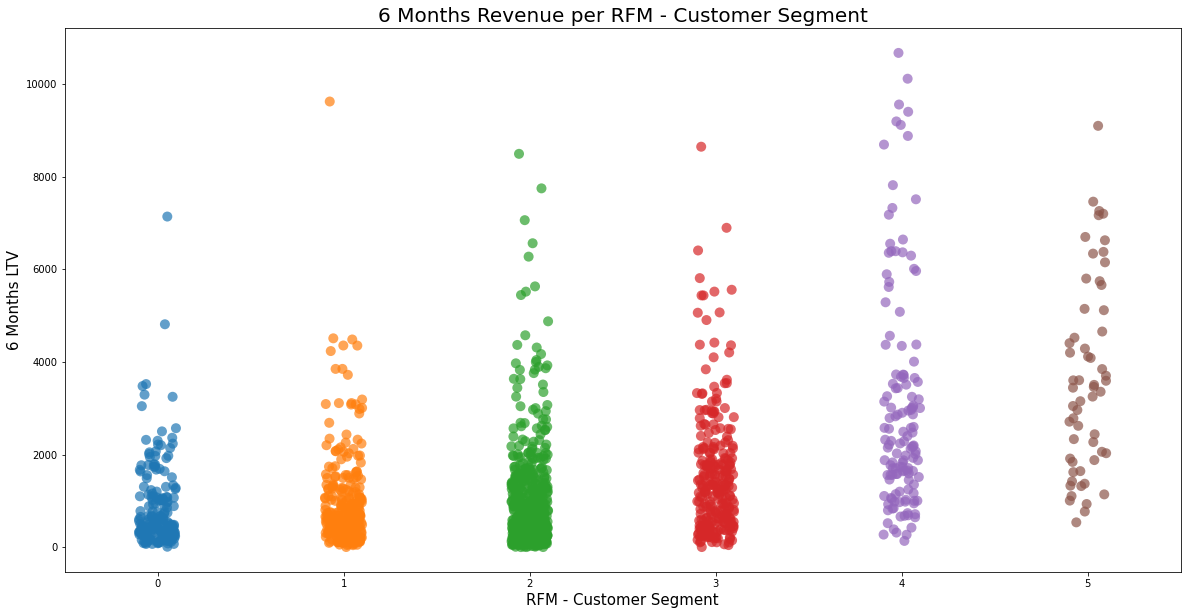

In [91]:
## plotting 6 months LTV distribution per RFM cluster
df_graph = df_merged.loc[df_merged["6m_Revenue"] < 30000]

plt.figure(figsize=(20,10))
sns.stripplot(data= df_graph,
                 x= df_graph["OverallScore"],
                 y= df_graph["6m_Revenue"],
                 size=10,
                 alpha= 0.7)

plt.title("6 Months Revenue per RFM - Customer Segment", size= 20)
plt.ylabel("6 Months LTV", size= 15)
plt.xlabel("RFM - Customer Segment", size= 15);

From the above graph it is visible that there seems to be a positive correlation between RFM scores and 6 months LTV.

### Clustering LTV

The business problem here is to predict which customers will have a high LTV, so that the business can act on that insight (e.g. with targeted marketing and retention campaigns).

Therefore, the target variable will be LTV - segments, which classify customers as having either high, medium, or low 6-months LTV.

In [92]:
## clustering 6 months LTV
kmeans = KMeans(n_clusters= 3, max_iter= 1000)
kmeans.fit(df_merged[["6m_Revenue"]])

df_merged["LTVCluster"]= kmeans.predict(df_merged[["6m_Revenue"]])

df_merged = order_cluster("LTVCluster", "6m_Revenue", df_merged, True)

In [93]:
df_merged.groupby("LTVCluster")["6m_Revenue"].describe()

count         mean          std      min       25%       50%  \
LTVCluster                                                                  
0           1040.0   672.890761   436.018430     7.50   313.320   576.325   
1            338.0  2622.549556   806.130163  1649.95  1950.250  2341.265   
2             64.0  6744.918125  1456.794465  4813.22  5627.025  6381.785   

                  75%       max  
LTVCluster                       
0           1004.0950   1645.92  
1           3148.1975   4656.66  
2           7355.6625  10665.82

## Feature Engineering

In [94]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler

In [95]:
df_merged.head(3)

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  Revenue  \
0     13880.0       25               2         38                 1   718.63   
1     17068.0       11               2         76                 1  1480.95   
2     15194.0        6               2         60                 1  1455.07   

   RevenueCluster  OverallScore    Segment  6m_Revenue  LTVCluster  
0               0             3  Low-Value     2193.14           1  
1               1             4  Mid-Value     2216.04           1  
2               1             4  Mid-Value     3248.71           1

In [96]:
## encoding the 'segment' column
final_df = pd.get_dummies(df_merged)
final_df.head()

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  Revenue  \
0     13880.0       25               2         38                 1   718.63   
1     17068.0       11               2         76                 1  1480.95   
2     15194.0        6               2         60                 1  1455.07   
3     12683.0       19               2         94                 1  2622.35   
4     17811.0        7               2        118                 2  1271.21   

   RevenueCluster  OverallScore  6m_Revenue  LTVCluster  Segment_Low-Value  \
0               0             3     2193.14           1                  1   
1               1             4     2216.04           1                  0   
2               1             4     3248.71           1                  0   
3               1             4     3261.52           1                  0   
4               1             5     3594.67           1                  0   

   Segment_Mid-Value  
0                  0  
1                  1  
2                  1  
3                  1  
4                  1

In [97]:
## scaling numerical features

for col in ["Recency", "Frequency", "Revenue"]:
    
    scaler = RobustScaler()
    
    scaler.fit(final_df[[col]])
    
    final_df[col] = scaler.transform(final_df[[col]])

In [98]:
## dropping 6 months revenue column (cannot be used for prediction due to data leakage)
#final_df.drop("6m_Revenue", axis= 1, inplace= True)

In [99]:
final_df.head()

CustomerID   Recency  RecencyCluster  Frequency  FrequencyCluster  \
0     13880.0  0.000000               2   0.256410                 1   
1     17068.0 -0.343558               2   1.230769                 1   
2     15194.0 -0.466258               2   0.820513                 1   
3     12683.0 -0.147239               2   1.692308                 1   
4     17811.0 -0.441718               2   2.307692                 2   

    Revenue  RevenueCluster  OverallScore  6m_Revenue  LTVCluster  \
0  0.413962               0             3     2193.14           1   
1  1.651887               1             4     2216.04           1   
2  1.609860               1             4     3248.71           1   
3  3.505395               1             4     3261.52           1   
4  1.311292               1             5     3594.67           1   

   Segment_Low-Value  Segment_Mid-Value  
0                  1                  0  
1                  0                  1  
2                  0                  1  
3                  0                  1  
4                  0                  1

In [100]:
## inspecting correlations within the data to assess which features might be useful

plt.figure(figsize=(15,10))
sns.heatmap(final_df.drop("CustomerID", axis=1).corr(), annot=True)

<AxesSubplot:>

## Modeling

Training the XGBoost algorithm to predict CLV.

### Classification

In [101]:
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error
from sklearn.dummy import DummyClassifier, DummyRegressor

In [102]:
final_df.head(3)

CustomerID   Recency  RecencyCluster  Frequency  FrequencyCluster  \
0     13880.0  0.000000               2   0.256410                 1   
1     17068.0 -0.343558               2   1.230769                 1   
2     15194.0 -0.466258               2   0.820513                 1   

    Revenue  RevenueCluster  OverallScore  6m_Revenue  LTVCluster  \
0  0.413962               0             3     2193.14           1   
1  1.651887               1             4     2216.04           1   
2  1.609860               1             4     3248.71           1   

   Segment_Low-Value  Segment_Mid-Value  
0                  1                  0  
1                  0                  1  
2                  0                  1

In [103]:
X = final_df.drop(["CustomerID", "LTVCluster", "6m_Revenue"], axis=1)
y = final_df[["LTVCluster"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25)

using all features for now, then testing with feature importace

In [104]:
## establishing prediction baseline
dummy = DummyClassifier()

dummy.fit(X_train, y_train)

acc = dummy.score(X_test, y_test)

print(f"The prediction accuracy baseline is {round(acc, 2)}")

The prediction accuracy baseline is 0.69


In [105]:
## instantiating and fitting XGBClassifier
clv_xgb_model_param = xgb.XGBClassifier(max_depth= 5,
                                 learning_rate= 0.1,
                                 objective= 'multi:softprob',
                                 n_jobs= -1)

clv_xgb_model = xgb.XGBClassifier()

clv_xgb_model_param.fit(X_train, y_train)

[18:26:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/garritwilson/.pyenv/versions/3.8.12/envs/li-monitoring/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

/Users/garritwilson/.pyenv/versions/3.8.12/envs/li-monitoring/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/garritwilson/.pyenv/versions/3.8.12/envs/li-monitoring/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [106]:
## evaluating XGB performance
acc = clv_xgb_model_param.score(X_test, y_test)

print(f"\nModel accuracy: {round(acc, 2)}\n")


Model accuracy: 0.73



In [107]:
## inspecting classification report from sklearn
y_pred = clv_xgb_model_param.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       248
           1       0.46      0.36      0.40        87
           2       0.64      0.27      0.38        26

    accuracy                           0.73       361
   macro avg       0.63      0.51      0.54       361
weighted avg       0.71      0.73      0.71       361



### Regression

In [108]:
final_df.head()

CustomerID   Recency  RecencyCluster  Frequency  FrequencyCluster  \
0     13880.0  0.000000               2   0.256410                 1   
1     17068.0 -0.343558               2   1.230769                 1   
2     15194.0 -0.466258               2   0.820513                 1   
3     12683.0 -0.147239               2   1.692308                 1   
4     17811.0 -0.441718               2   2.307692                 2   

    Revenue  RevenueCluster  OverallScore  6m_Revenue  LTVCluster  \
0  0.413962               0             3     2193.14           1   
1  1.651887               1             4     2216.04           1   
2  1.609860               1             4     3248.71           1   
3  3.505395               1             4     3261.52           1   
4  1.311292               1             5     3594.67           1   

   Segment_Low-Value  Segment_Mid-Value  
0                  1                  0  
1                  0                  1  
2                  0                  1  
3                  0                  1  
4                  0                  1

In [109]:
## splitting the dataset into training and test data
X = final_df.drop(["CustomerID", "LTVCluster", "6m_Revenue"], axis= 1)
y = final_df[["6m_Revenue"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25)

In [110]:
## establishing regression baseline scores
dummy = DummyRegressor()

dummy.fit(X_train, y_train)

y_pred = dummy.predict(X_test)

r2 = dummy.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

results = {
    "metric": ["r2", "mse", "rmse", "mae"],
    "value": [r2, mse, rmse, mae]
}

pd.DataFrame(results).set_index("metric").round(2)

value
metric            
r2           -0.00
mse     2200733.48
rmse       1483.49
mae        1064.04

In [111]:
## predicting 6-months LTV using XGBRegressor
xgb_regressor = xgb.XGBRegressor()

xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

r2 = xgb_regressor.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

results = {
    "metric": ["r2", "mse", "rmse", "mae"],
    "value": [r2, mse, rmse, mae]
}

pd.DataFrame(results).set_index("metric").round(2)

value
metric            
r2            0.30
mse     1544293.98
rmse       1242.70
mae         824.31

## Conclusion

Currently, the model is performing barely better than the baseline model (DummyClassifier) with regards to classification.

This is likely due to strong imbalance in the dataset when it comes to the target variable.

Possible solutionw would be: 

- to apply balancing, for example by creating synthetic data for LTVClusters 1 & 2.

- to do more hyperparameter tuning

- to test different classifiers

- to use deep learning (neural networks)

The regression model on the other hand seems to perform very well, with r2 value of 0.99, a root mean squared error of 118.35 and a mean absolute error of 29.61.

# Sandbox

In [112]:
from sklearn.model_selection import train_test_split, cross_validate

In [113]:
def modeling(df):
    '''This function fits an XGBRegressor algorithm to the data,
    and predicts the lifetime value per Customer.'''
    
    X = df.drop(["CustomerID", "6m_Revenue", "LTVCluster"], axis= 1)
    y= df["6m_Revenue"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25)
    
    xgb_regressor = xgb.XGBRegressor()
    
    xgb_regressor.fit(X_train, y_train)
    
    cv_results = cross_validate(xgb_regressor,
                               X= X_train,
                               y= y_train,
                               cv= 5,
                               scoring= ["neg_mean_squared_error"])
    
    score = abs(cv_results["test_neg_mean_squared_error"].mean())
    
    print(f'RMSE of XGBRegressor: {math.sqrt(score)}')
    
    return df, (X_train, X_test, y_train, y_test), xgb_regressor

In [114]:
df_pred, data_split, model = modeling(final_df)

X_train, X_test, y_train, y_test = data_split[0], data_split[1], data_split[2], data_split[3]

RMSE of XGBRegressor: 1233.8156279406946


In [115]:
predicted_ltv = X_test
predicted_ltv["Predicted_LTV"] = model.predict(predicted_ltv)

predicted_ltv["CustomerID"] = list(range(0, len(predicted_ltv)))
predicted_ltv["Actual_LTV"] = y_test

predicted_ltv= predicted_ltv[["CustomerID", "Actual_LTV", "Predicted_LTV"]]


In [116]:
predicted_ltv

CustomerID  Actual_LTV  Predicted_LTV
996            0     1077.47     321.416321
1147           1     1498.29     426.079712
518            2     1099.95     850.588013
417            3      711.90    1838.866943
519            4      393.40    1705.423828
...          ...         ...            ...
381          356     7136.34    4817.613281
1236         357      717.02     916.007507
139          358     3194.90    1707.285767
473          359      689.30      86.562202
493          360     1642.88     394.666748

[361 rows x 3 columns]

In [117]:
sample = predicted_ltv.sample(n= 50)

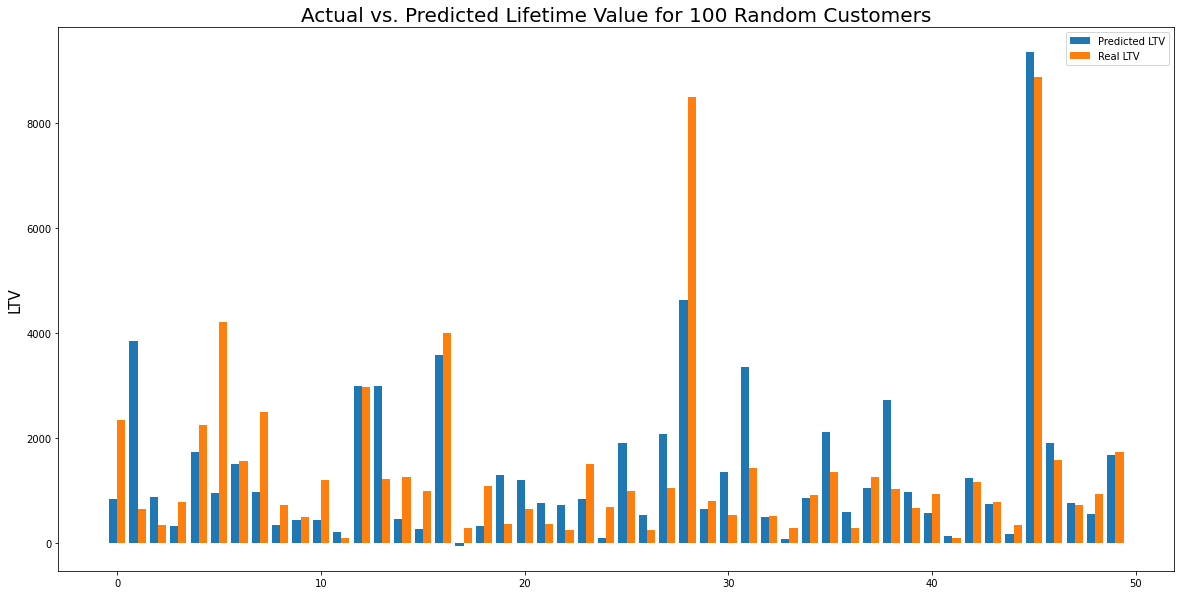

In [118]:
X= sample["CustomerID"]
Y1 = sample["Predicted_LTV"]
Y2 = sample["Actual_LTV"]

X_axis = np.arange(len(X))

plt.figure(figsize=(20,10))
plt.bar(X_axis - 0.2, Y1, 0.4, label = 'Predicted LTV')
plt.bar(X_axis + 0.2, Y2, 0.4, label = 'Real LTV')

plt.title("Actual vs. Predicted Lifetime Value for 100 Random Customers", size= 20)
plt.ylabel('LTV', size= 15)
plt.legend();

In [119]:
comparison_df = sample[["Actual_LTV", "Predicted_LTV"]].copy()

comparison_df["error"] = comparison_df["Actual_LTV"] - comparison_df["Predicted_LTV"]

comparison_df.head()

Actual_LTV  Predicted_LTV        error
211      2346.29     840.497742  1505.792258
500       644.50    3844.245117 -3199.745117
983       341.27     866.909424  -525.639424
1317      775.97     315.327057   460.642943
191      2240.87    1741.727417   499.142583

<BarContainer object of 50 artists>

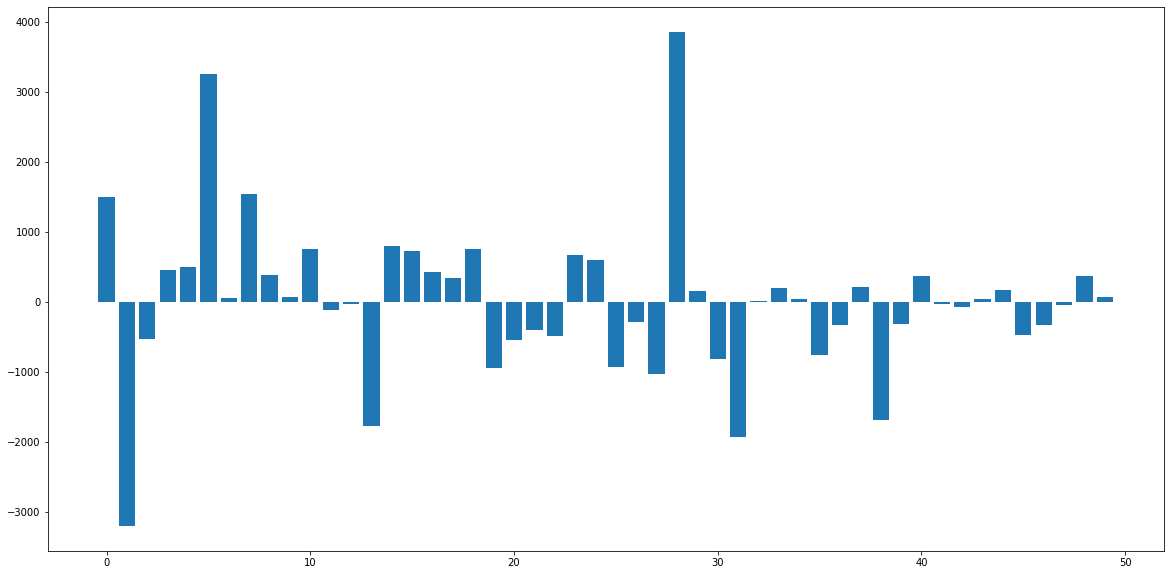

In [120]:
plt.figure(figsize=(20,10))
plt.bar(list(range(0,len(comparison_df))),comparison_df["error"])